In [1]:
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader

from PhaseFunctionedNetwork import PhaseFunctionedNetwork
from train_utils import train_pfnn_thresh

# set seeds for reproduceability
torch.manual_seed(42)
np.random.seed(42)
rng = np.random.RandomState(42)

# Style 1 - Idle
# Style 2 - Jump
    # 0 - flat
    # 1 - up 
    # 2 - down

# Expriments with all data varieties

In [2]:
ROUND = 2
INPUT_PATH = 'Input_'
OUTPUT_PATH = 'Output_'

def get_change_in_phase(phase_arr):
    change_in_phase =  phase_arr[1:] - phase_arr[:-1]
    change_in_phase[change_in_phase < 0] = (1.0 - phase_arr[:-1] + phase_arr[1:])[change_in_phase < 0]
    change_in_phase = np.append(change_in_phase, change_in_phase[-1]) #TODO IF BREAKS append 2pi
    return change_in_phase

def get_phase_acyclic(X_arr):
    # P_arr = np.round(np.linspace(0, 0.99, num=X_arr.shape[0]), ROUND)
    P_arr = np.linspace(0, 0.99, num=X_arr.shape[0])

    return P_arr

def get_phase_cyclic(X_arr, num_repetitions):
    total_len = X_arr.shape[0]
    
    cycle_len = total_len // num_repetitions
    cycle = np.linspace(0, 0.99, num=cycle_len, endpoint=False)
    # Repeat
    P_arr = np.tile(cycle, num_repetitions)

    # If not long enough add from beggining of cycle
    P_arr_len = len(P_arr)
    if P_arr_len < total_len:
        pad_to = total_len - P_arr_len
        P_arr = np.concatenate([P_arr, cycle[:pad_to]])

    # P_arr = np.round(P_arr, ROUND)
    return P_arr

In [3]:
INPUT_PREFIX = 'Input_'
OUTPUT_PREFIX = 'Output_'

EXTENSION = '.txt'

def load_data(data_dir, action_num):
    X_arr = np.float32(np.loadtxt(data_dir + INPUT_PREFIX + action_num + EXTENSION))
    Y_arr = np.float32(np.loadtxt(data_dir + OUTPUT_PREFIX + action_num + EXTENSION))
    
    return X_arr, Y_arr

def process_data(X_arr, Y_arr, P_arr, delta_phase_arr, num_files, data_dir, split_stats_arr, cyclic_action=True):
    prev_data = sum(arr.shape[0] for arr in X_arr) + sum(arr.shape[0] for arr in Y_arr) 
    for i in range(int(num_files/2)):
        input_data, output_data = load_data(data_dir, str(i))

        if(cyclic_action):
            phase_data = get_phase_cyclic(input_data, 3)
        else:
            phase_data = get_phase_acyclic(input_data)

        change_in_phase = get_change_in_phase(phase_data)

        X_arr.append(input_data)
        Y_arr.append(output_data)
        P_arr = np.append(P_arr, phase_data)
        delta_phase_arr = np.append(delta_phase_arr, change_in_phase)

    current_data = sum(arr.shape[0] for arr in X_arr) + sum(arr.shape[0] for arr in Y_arr)
    split_stats_arr.append(current_data - prev_data)

    return X_arr, Y_arr, P_arr, delta_phase_arr, split_stats_arr

In [4]:
# WEIGH THE JOINT (in particular all the hand and foot joints need to be weighted less)
JOINT_NUM = 144

joint_weights = np.array([
    1,                                                  # HIPS
    1, 1, 1,                                            # LEFT leg
    1e-10, 1e-10, 1e-10, 1,                             # LEFT foot thumb
    1,                                                  # LEFT foot toe base
    1e-10, 1e-10, 1e-10, 1,                             # LEFT foot index
    1e-10, 1e-10, 1e-10, 1e-10, 1,                      # LEFT foot middle
    1e-10, 1e-10, 1e-10, 1e-10, 1,                      # LEFT foot ring
    1, 1, 1,                                            # RIGHT leg
    1e-10, 1e-10, 1e-10, 1,                             # RIGHT foot thumb
    1,                                                  # RIGHT foot toe base
    1e-10, 1e-10, 1e-10, 1,                             # RIGHT foot index
    1e-10, 1e-10, 1e-10, 1e-10, 1,                      # RIGHT foot middle
    1e-10, 1e-10, 1e-10, 1e-10, 1,                      # RIGHT foot ring
    1, 1, 1, 1,                                         # SPINE
    1, 1,                                               # LEFT shoulder
    1, 1,                                               # LEFT arm
    1,                                                  # LEFT hand
    1e-10, 1e-10, 1e-10, 1e-10, 1,                      # LEFT hand index
    1e-10, 1e-10, 1e-10, 1e-10, 1,                      # LEFT hand middle
    1e-10, 1e-10, 1e-10, 1e-10, 1,                      # LEFT hand ring
    1, 1e-10, 1,                                        # LEFT wing feathers large
    1, 1e-10, 1,                                        # LEFT wing feathers medium
    1,                                                  # LEFT wing feathers small
    1, 1, 1, 1, 1, 1, 1,                                # NECK
    1,                                                  # HEAD
    1e-10, 1e-10,                                       # JAW
    1e-10, 1e-10, 1e-10, 1e-10, 1e-10, 1e-10, 1e-10,    # TONUGE
    1e-10, 1e-10, 1e-10,                                # LEFT eye
    1e-10, 1e-10, 1e-10,                                # RIGHT eye
    1, 1,                                               # RIGHT shoulder
    1, 1,                                               # RIGHT arm
    1,                                                  # RIGHT hand
    1e-10, 1e-10, 1e-10, 1e-10, 1,                      # RIGHT hand index
    1e-10, 1e-10, 1e-10, 1e-10, 1,                      # RIGHT hand middle
    1e-10, 1e-10, 1e-10, 1e-10, 1,                      # RIGHT hand ring
    1, 1e-10, 1,                                        # RIGHT wing feathers large
    1, 1e-10, 1,                                        # RIGHT wing feathers medium
    1,                                                  # RIGHT wing feathers small
    1, 1, 1, 1, 1, 1, 1, 1, 1,                          # TAIL
    1e-10, 1e-10, 1,                                    # LEFT tail feather
    1e-10, 1e-10, 1,                                    # MIDDLE tail feather         
    1e-10, 1e-10, 1                                     # RIGHT tail feather 
])

# repeat weights for each joint to represent X, Y and Z
joint_weights = joint_weights.repeat(3)

In [76]:
# Automatic processing of idle and jumps
ROOT_DIR = 'C:/Users/Ana/Desktop/dev/pfnn-dev/Export/chapter4_data_aug_root/v2.2/'
IDLE_DATA_DIR = ROOT_DIR + 'idle/'
JUMP_DATA_DIR = ROOT_DIR + 'jump/'

split_stats = []
X = []
Y = []
P = np.empty(0)
delta_phase = np.empty(0)

# Process idle data
file_count = sum(1 for filename in os.listdir(IDLE_DATA_DIR) if filename.endswith('.txt'))
X, Y, P, delta_phase, split_stats = process_data(X, Y, P, delta_phase, file_count, data_dir=IDLE_DATA_DIR, split_stats_arr=split_stats, cyclic_action=True)

# Process jump data
file_count = sum(1 for filename in os.listdir(JUMP_DATA_DIR) if filename.endswith('.txt'))
X, Y, P, delta_phase, split_stats = process_data(X, Y, P, delta_phase, file_count, data_dir=JUMP_DATA_DIR, split_stats_arr=split_stats, cyclic_action=False)

In [77]:
# stack all the arrays on top of each other
X = np.vstack(X)
Y = np.vstack(Y)
delta_phase = delta_phase.flatten()
P = P.flatten()
Y = np.concatenate([Y, delta_phase [..., np.newaxis]], axis=-1)

# print stats 
print(f"Input data shape: {X.shape}")
print(f"Output data shape: {Y.shape}")
print(f"Phase data shape: {P.shape}")
print(f"Delta phase shape: {delta_phase.shape}")

# Action 0 --> Idle
# Action 1 --> Jump
# print data distribution stats (walk/idle) 
total_data = sum(data for data in split_stats)
for i in range(len(split_stats)):
    print(f"Action {i} = {np.round(split_stats[i]/total_data * 100, 2)}%")

Input data shape: (13289, 960)
Output data shape: (13289, 892)
Phase data shape: (13289,)
Delta phase shape: (13289,)
Action 0 = 0.54%
Action 1 = 99.46%


In [78]:
def preprocess_X_2Styles(X_arr):
    Xmean, Xstd = X_arr.mean(axis=0), X_arr.std(axis=0)

    # lists to keep track of indices for TRAJECTORY
    X_traj_pos_indices = []
    X_traj_dir_indices = []
    X_traj_style_indices = []
    X_traj_slope_indices = []

    # number of eleements for each trajectory point
    w = 8
    for i in range(0, 95, w):
        X_traj_pos_indices = np.append(X_traj_pos_indices, range(i,i+3)).astype(int)
        X_traj_dir_indices = np.append(X_traj_dir_indices, range(i+3,i+5)).astype(int)
        X_traj_slope_indices = np.append(X_traj_slope_indices, i+5).astype(int)
        X_traj_style_indices = np.append(X_traj_style_indices, range(i+6,i+8)).astype(int)

    # lists to keep track of indices for JOINTS
    X_joint_pos_indices = []
    X_joint_vel_indices = []

    # num of elements for each joint
    w = 6
    for i in range(96, 959, w):
        X_joint_pos_indices = np.append(X_joint_pos_indices, range(i,i+3)).astype(int)
        X_joint_vel_indices = np.append(X_joint_vel_indices, range(i+3,i+6)).astype(int)

    # INPUT Trajectory data
    Xstd[X_traj_pos_indices] = Xstd[X_traj_pos_indices].mean()
    Xstd[X_traj_dir_indices] = Xstd[X_traj_dir_indices].mean()
    Xstd[X_traj_style_indices] = Xstd[X_traj_style_indices].mean()
    Xstd[X_traj_slope_indices] = Xstd[X_traj_slope_indices].mean()

    # INPUT Joint data --> This is where we weight the joints
    Xstd[X_joint_pos_indices] = Xstd[X_joint_pos_indices].mean() / (joint_weights * 0.1)
    # Xstd[X_joint_vel_indices] = Xstd[X_joint_vel_indices].mean() / (joint_weights * 0.1)
    # Xstd[X_joint_pos_indices] = Xstd[X_joint_pos_indices].mean() 
    # Xstd[X_joint_vel_indices] = Xstd[X_joint_vel_indices].mean()

    return Xmean, Xstd

def preprocess_Y(Y_arr):
    Ymean, Ystd = Y_arr.mean(axis=0), Y_arr.std(axis=0)

    # PREPROCESS OUTPUT Y
    # lists to keep track of indices for TRAJECTORY
    Y_traj_pos_indices = []
    Y_traj_dir_indices = []

    # number of trajectory elements
    w = 4
    for i in range(0, 23, w): #TODO UPDATE THE RANGE
        Y_traj_pos_indices = np.append(Y_traj_pos_indices, range(i,i+2)).astype(int)
        Y_traj_dir_indices = np.append(Y_traj_dir_indices, range(i+2,i+4)).astype(int)

    # lists to keep track of indices for JOINTS
    Y_joint_pos_indices = []
    Y_joint_vel_indices = []

    # num of joint elements
    w = 6
    for i in range(24, 887, w): #TODO UPDATE THE RANGE
        Y_joint_pos_indices = np.append(Y_joint_pos_indices, range(i,i+3)).astype(int)
        Y_joint_vel_indices = np.append(Y_joint_vel_indices, range(i+3,i+6)).astype(int)

    # OUTPUT Trajectory data
    Ystd[Y_traj_pos_indices] = Ystd[Y_traj_pos_indices].mean()
    Ystd[Y_traj_dir_indices] = Ystd[Y_traj_dir_indices].mean()

    # OUTPUT Joint data --> This is where we weight the joints
    Ystd[Y_joint_pos_indices] = Ystd[Y_joint_pos_indices].mean()
    Ystd[Y_joint_vel_indices] = Ystd[Y_joint_vel_indices].mean()
    
    # translational_vel_mean = (Ystd[-4] + Ystd[-2])/2
    # Ystd[-4] = translational_vel_mean
    # Ystd[-2] = translational_vel_mean

    return Ymean, Ystd

In [79]:
# Preprocess Data
Xmean, Xstd = preprocess_X_2Styles(X)
Ymean, Ystd = preprocess_Y(Y)

WEIGHTS_SAVE_PATH = 'C:/Users/Ana/Desktop/dev/pfnn-dev/unity-pfnn/Assets/Dev/Weights/test/'

for i in range(Xstd.size):
    if (Xstd[i]==0):
        Xstd[i]=1
for i in range(Ystd.size):
    if (Ystd[i]==0):
        Ystd[i]=1

# save means and stds
Xmean.astype(np.float32).tofile(WEIGHTS_SAVE_PATH + 'Xmean.bin')
Ymean.astype(np.float32).tofile(WEIGHTS_SAVE_PATH + 'Ymean.bin')
Xstd.astype(np.float32).tofile(WEIGHTS_SAVE_PATH + 'Xstd.bin')
Ystd.astype(np.float32).tofile(WEIGHTS_SAVE_PATH + 'Ystd.bin')

# normalize data NOTE ORIGINAL DID THIS AFTER SAVING THE MEANS AND STD AS DONE HERE
X = (X - Xmean) / Xstd
Y = (Y - Ymean) / Ystd

# load data for PyTorch training

# append phase as additional feature only for training NN
input = torch.tensor(np.concatenate([X, P [..., np.newaxis]], axis=-1))
target = torch.tensor(Y)

print(f"Input shape {input.shape}")
print(f"Target shape {target.shape}")

dataset = TensorDataset(input, target)

Input shape torch.Size([13289, 961])
Target shape torch.Size([13289, 892])


In [80]:
# Define PFNN
model = PhaseFunctionedNetwork(input_shape=input.shape[1], output_shape=target.shape[1], dropout=0.7)

# Determine device for training 
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(DEVICE)

# Training variables
BATCH_SIZE = 32
EPOCHS = 5
# NOTE USUALLY 0.0001
LR = 0.0001
OPTIMIZER = torch.optim.AdamW(model.parameters(), lr=LR)
train_dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

# Train
model, loss_history = train_pfnn_thresh(model, train_dataloader, optimizer=OPTIMIZER, num_epochs=EPOCHS, device=DEVICE, threshold=0.000001)

# Save
model.precompute_and_save_weights()

100%|██████████| 416/416 [00:38<00:00, 10.80it/s]


Epoch [1/5], Loss: 0.3979830201426923
inf


100%|██████████| 416/416 [00:39<00:00, 10.58it/s]


Epoch [2/5], Loss: 0.16357596972905133
0.234407050413641


100%|██████████| 416/416 [00:37<00:00, 11.07it/s]


Epoch [3/5], Loss: 0.13838927586119734
0.025186693867853993


100%|██████████| 416/416 [00:37<00:00, 11.11it/s]


Epoch [4/5], Loss: 0.12542207826038893
0.012967197600808417


100%|██████████| 416/416 [00:39<00:00, 10.43it/s]


Epoch [5/5], Loss: 0.11722880833991908
0.008193269920469842


In [57]:
STATS_ROOT_DIR = 'C:/Users/Ana/Desktop/dev/pfnn-dev/TrainingStats/'
SAVE_FOLDER_DIR = '4_data_aug/root_traj/'
np.save(STATS_ROOT_DIR + SAVE_FOLDER_DIR + 'v2.2_LR1e-6_losshist.npy', loss_history)

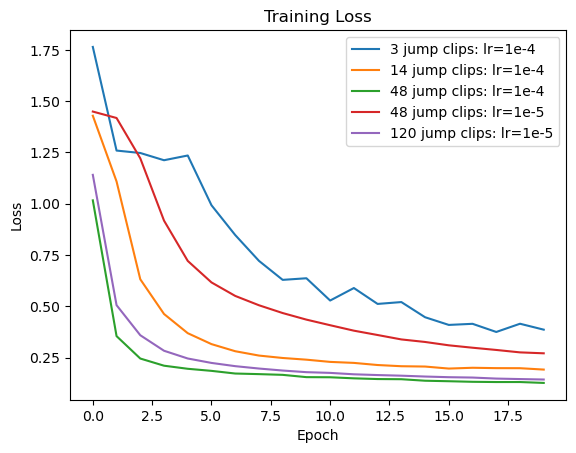

In [40]:
# # Plot
v1_0 = np.load('C:/Users/Ana/Desktop/dev/pfnn-dev/TrainingStats/4_data_aug/root_traj/v1.0_LR1e-4_losshist.npy')
v2_0 = np.load('C:/Users/Ana/Desktop/dev/pfnn-dev/TrainingStats/4_data_aug/root_traj/v2.0_LR1e-4_losshist.npy')
v2_1_lr4 = np.load('C:/Users/Ana/Desktop/dev/pfnn-dev/TrainingStats/4_data_aug/root_traj/v2.1_LR1e-4_losshist.npy')
v2_1_lr5 = np.load('C:/Users/Ana/Desktop/dev/pfnn-dev/TrainingStats/4_data_aug/root_traj/v2.1_LR1e-5_losshist.npy')
v2_2_lr5 = np.load('C:/Users/Ana/Desktop/dev/pfnn-dev/TrainingStats/4_data_aug/root_traj/v2.2_LR1e-5_losshist.npy')

# Create corresponding x values for each array
x0 = np.arange(len(v1_0))
x1 = np.arange(len(v2_0))
x2 = np.arange(len(v2_1_lr4))
x3 = np.arange(len(v2_1_lr5))
x4 = np.arange(len(v2_2_lr5))

# Plot both arrays on the same plot
plt.plot(x0, v1_0, label='3 jump clips: lr=1e-4')
plt.plot(x1, v2_0, label='14 jump clips: lr=1e-4')
plt.plot(x2, v2_1_lr4, label='48 jump clips: lr=1e-4')
plt.plot(x3, v2_1_lr5, label='48 jump clips: lr=1e-5')
plt.plot(x4, v2_2_lr5, label='120 jump clips: lr=1e-5')

# Add title and labels
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

# Add a legend
plt.legend()

# Display the plot
plt.show()